In [1]:
import numpy as np
import os
from keras import backend as K
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from time import time

from tensorflow.keras.datasets import cifar10

Using TensorFlow backend.


In [2]:
def id_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    X_shortcut = X
   
    X = Conv2D(filters=filters, kernel_size=(1, 1), strides=(1, 1), padding='same', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)


    X = Conv2D(filters=filters, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [3]:
def conv_block(X, f, filters, stage, block, s=2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    X_shortcut = X
    
    X = Conv2D(filters=filters, kernel_size=(1, 1), strides=(s, s), padding='same', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters=filters, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    
    X_shortcut = Conv2D(filters=filters, kernel_size=(1, 1), strides=(s, s), padding='same', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [4]:
def ResNet18(input_shape=(28, 28, 1)):

    # Input 
    X_input = Input(input_shape)
    
    #X = ZeroPadding2D((3, 3))(X_input)

    # Conv1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0), padding="same")(X_input)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2), padding="same")(X)

    # Layer 1
    X = id_block(X, 3, 64, stage=2, block='a')
    X = id_block(X, 3, 64, stage=2, block='b')

    # Layer 2
    X = conv_block(X, f=3, filters=128, stage=3, block='a', s=2)
    X = id_block(X, 3, 128, stage=3, block='b')

    # Layer 3
    X = conv_block(X, f=3, filters=256, stage=4, block='a', s=2)
    X = id_block(X, 3, 256, stage=4, block='b')

    # Layer 4
    X = X = conv_block(X, f=3, filters=512, stage=5, block='a', s=2)
    X = id_block(X, 3, 512, stage=5, block='b')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet18')

    return model

In [5]:
(train_x, train_y), (test_x, test_y) = cifar10.load_data()

# normalize to range 0-1
train_x = train_x / 255.0
test_x = test_x / 255.0

val_x = train_x[:5000]
val_y = train_y[:5000]

In [6]:
Input18 = ResNet18(train_x[0].shape)

In [7]:
headModel18 = Input18.output
# Flatten
headModel18 = Flatten()(headModel18)
# FC
headModel18 = Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel18)
headModel18 = Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel18)
# Output
headModel18 = Dense(10,activation='softmax', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel18)

In [8]:
model18 = Model(inputs=Input18.input, outputs=headModel18)

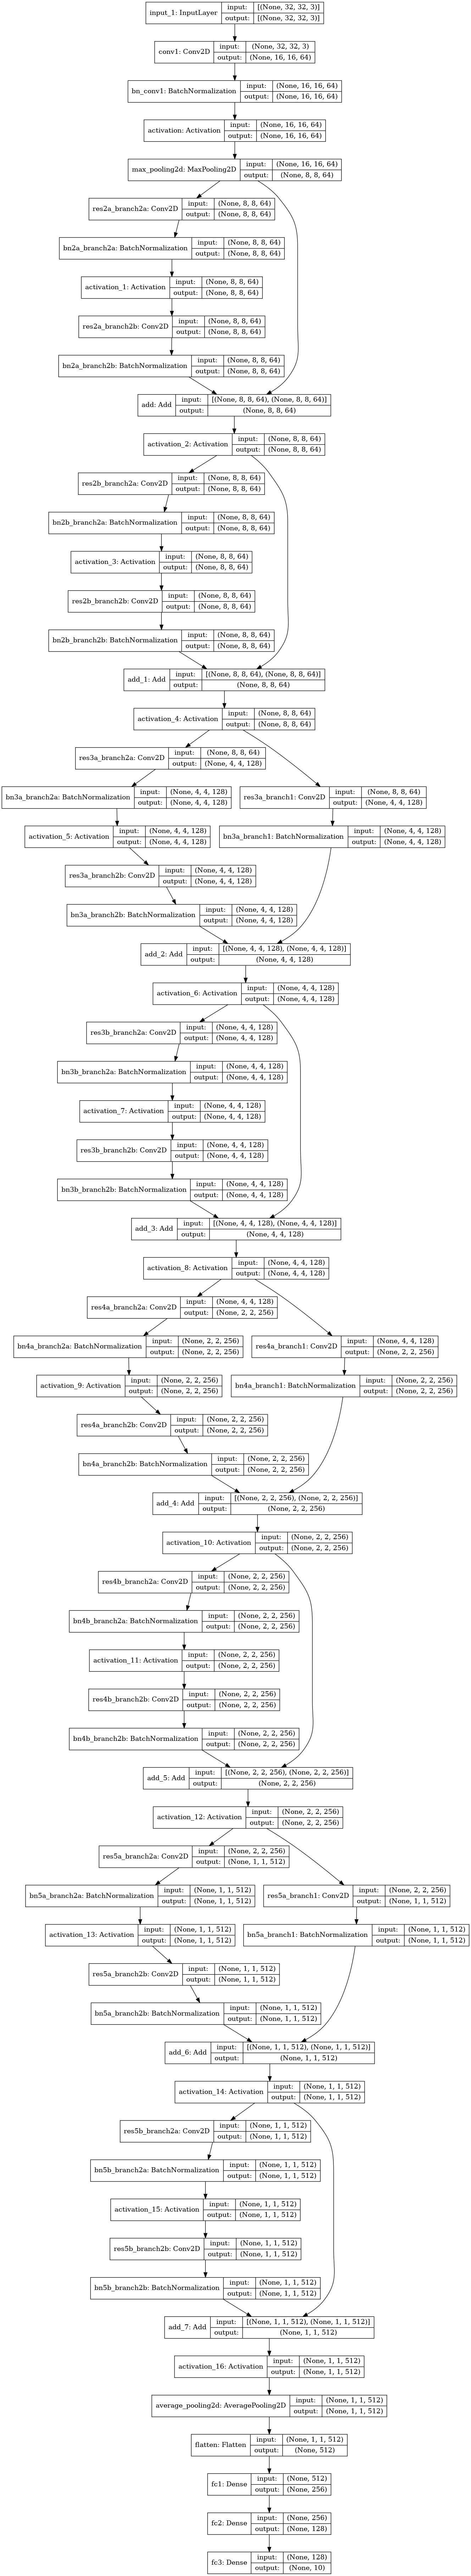

In [9]:
plot_model(model18, show_shapes=True)

In [10]:
model18.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
#model18.summary()
len(model18.layers)

72

In [11]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=1)
list_cb = [es]

In [12]:
start = time()
model18.fit( train_x , train_y , epochs=50, batch_size=1024, validation_split=0.3, callbacks=list_cb)
training_time = time()-start

Epoch 1/50
35/35 [==============================] - 250s 7s/step - loss: 2.1195 - accuracy: 0.2868 - val_loss: 2.3101 - val_accuracy: 0.1287
Epoch 2/50
35/35 [==============================] - 234s 7s/step - loss: 1.3388 - accuracy: 0.5147 - val_loss: 2.3982 - val_accuracy: 0.0985
Epoch 3/50
35/35 [==============================] - 234s 7s/step - loss: 1.1200 - accuracy: 0.5986 - val_loss: 2.6111 - val_accuracy: 0.0983
Epoch 4/50
35/35 [==============================] - 226s 6s/step - loss: 0.9516 - accuracy: 0.6576 - val_loss: 2.7558 - val_accuracy: 0.1005
Epoch 5/50
35/35 [==============================] - 230s 7s/step - loss: 0.8174 - accuracy: 0.7119 - val_loss: 2.5207 - val_accuracy: 0.2109
Epoch 6/50
35/35 [==============================] - 231s 7s/step - loss: 0.6742 - accuracy: 0.7617 - val_loss: 2.8338 - val_accuracy: 0.1911
Epoch 7/50
35/35 [==============================] - 228s 7s/step - loss: 0.5886 - accuracy: 0.7921 - val_loss: 2.9106 - val_accuracy: 0.2289
Epoch 8/50
35

In [13]:
model18.evaluate(test_x, test_y)

313/313 [==============================] - 21s 67ms/step - loss: 2.0802 - accuracy: 0.6006


[2.0802249908447266, 0.600600004196167]

In [14]:
model18.evaluate(train_x, train_y)

1563/1563 [==============================] - 76s 49ms/step - loss: 0.9030 - accuracy: 0.7930


[0.9029771089553833, 0.792959988117218]

In [15]:
training_time

4237.398499965668